Department Performance (Mean Marks):
department_x
Physics             80.000000
Mathematics         76.666667
Computer Science    72.500000
Name: marks, dtype: float64

Subjects with highly skewed distributions:
Series([], Name: marks, dtype: float64)

Top Students (Consistently High Performers):
student_id  name   
3           Charlie    83.333333
1           Alice      81.666667
2           Bob        80.000000
6           Frank      76.666667
5           Eva        73.333333
4           David      63.333333
Name: marks, dtype: float64

Percentage of students scoring above one std dev: 16.67%

Department with maximum performance variation:
department_x
Physics    271.6
Name: marks, dtype: float64

Total anomalies detected: 0
Empty DataFrame
Columns: [student_id, name, subject_name, marks, z_score]
Index: []


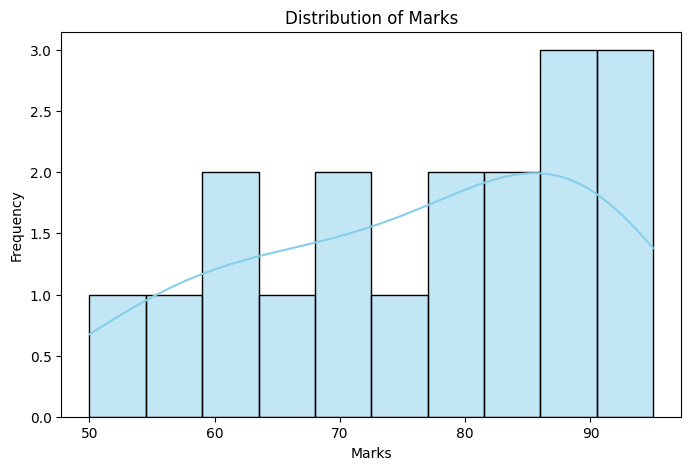

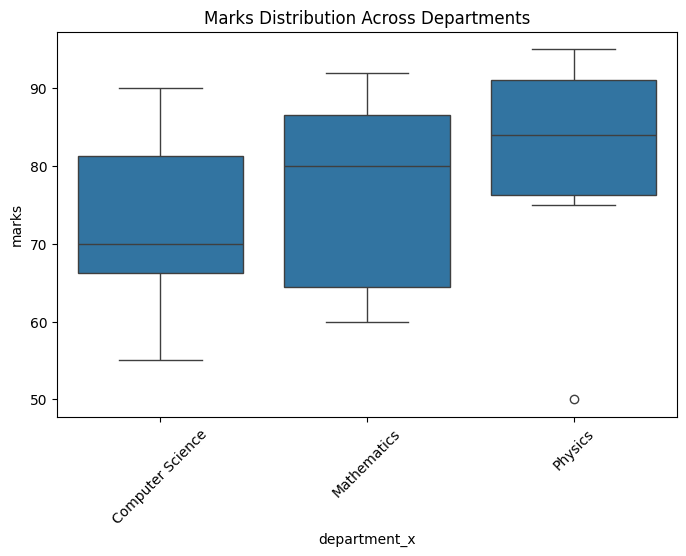

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, zscore

conn = sqlite3.connect("university.db")
cursor = conn.cursor()

# Drop tables if they exist (for clean reruns)
cursor.execute("DROP TABLE IF EXISTS students")
cursor.execute("DROP TABLE IF EXISTS subjects")
cursor.execute("DROP TABLE IF EXISTS marks")

# Create tables
cursor.execute("""
CREATE TABLE students (
    student_id INTEGER PRIMARY KEY,
    name TEXT,
    department TEXT,
    year INTEGER
)
""")

cursor.execute("""
CREATE TABLE subjects (
    subject_id INTEGER PRIMARY KEY,
    subject_name TEXT,
    department TEXT
)
""")

cursor.execute("""
CREATE TABLE marks (
    student_id INTEGER,
    subject_id INTEGER,
    marks INTEGER
)
""")

# -----------------------------
# Insert Sample Data
# -----------------------------
students_data = [
    (1, "Alice", "Computer Science", 2),
    (2, "Bob", "Mathematics", 2),
    (3, "Charlie", "Physics", 3),
    (4, "David", "Computer Science", 1),
    (5, "Eva", "Mathematics", 3),
    (6, "Frank", "Physics", 2),
]

subjects_data = [
    (1, "Algorithms", "Computer Science"),
    (2, "Databases", "Computer Science"),
    (3, "Calculus", "Mathematics"),
    (4, "Statistics", "Mathematics"),
    (5, "Quantum Mechanics", "Physics"),
    (6, "Electromagnetism", "Physics"),
]

marks_data = [
    (1, 1, 85), (1, 2, 90), (1, 3, 70),
    (2, 3, 88), (2, 4, 92), (2, 1, 60),
    (3, 5, 95), (3, 6, 80), (3, 4, 75),
    (4, 1, 65), (4, 2, 70), (4, 3, 55),
    (5, 3, 78), (5, 4, 82), (5, 6, 60),
    (6, 5, 88), (6, 6, 92), (6, 2, 50),
]

cursor.executemany("INSERT INTO students VALUES (?, ?, ?, ?)", students_data)
cursor.executemany("INSERT INTO subjects VALUES (?, ?, ?)", subjects_data)
cursor.executemany("INSERT INTO marks VALUES (?, ?, ?)", marks_data)

conn.commit()

# -----------------------------
# Load Data into Pandas
# -----------------------------
students = pd.read_sql("SELECT * FROM students", conn)
subjects = pd.read_sql("SELECT * FROM subjects", conn)
marks = pd.read_sql("SELECT * FROM marks", conn)

# -----------------------------
# JOIN Strategy
# -----------------------------
df = (marks
      .merge(students, on="student_id", how="inner")
      .merge(subjects, on="subject_id", how="inner"))

# -----------------------------
# Department Performance (Mean Marks)
# -----------------------------
dept_perf = df.groupby("department_x")["marks"].mean().sort_values(ascending=False)
print("Department Performance (Mean Marks):")
print(dept_perf)

# -----------------------------
# Skewness of Subjects
# -----------------------------
subject_skew = df.groupby("subject_name")["marks"].apply(lambda x: skew(x))
highly_skewed = subject_skew[abs(subject_skew) > 1]
print("\nSubjects with highly skewed distributions:")
print(highly_skewed)

# -----------------------------
# Consistently High-Performing Students
# -----------------------------
student_avg = df.groupby(["student_id", "name"])["marks"].mean()
top_students = student_avg.sort_values(ascending=False).head(10)
print("\nTop Students (Consistently High Performers):")
print(top_students)

# -----------------------------
# Percentage Above One Std Dev
# -----------------------------
mean_marks = df["marks"].mean()
std_marks = df["marks"].std()
threshold = mean_marks + std_marks
above_std = (df["marks"] > threshold).mean() * 100
print(f"\nPercentage of students scoring above one std dev: {above_std:.2f}%")

# -----------------------------
# Department with Maximum Variation
# -----------------------------
dept_var = df.groupby("department_x")["marks"].var().sort_values(ascending=False)
print("\nDepartment with maximum performance variation:")
print(dept_var.head(1))

# -----------------------------
# Z-score Based Anomaly Detection
# -----------------------------
df["z_score"] = zscore(df["marks"])
df["anomaly"] = df["z_score"].apply(lambda z: abs(z) > 2.5)
anomalies = df[df["anomaly"]]
print(f"\nTotal anomalies detected: {len(anomalies)}")
print(anomalies[["student_id", "name", "subject_name", "marks", "z_score"]].head())

# -----------------------------
# Visualization Examples
# -----------------------------
plt.figure(figsize=(8,5))
sns.histplot(df["marks"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of Marks")
plt.xlabel("Marks")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="department_x", y="marks", data=df)
plt.title("Marks Distribution Across Departments")
plt.xticks(rotation=45)
plt.show()

conn.close()